<a href="https://colab.research.google.com/github/fluderm/Fellowship.ai/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
assert sys.version_info >= (3, 5)

if "google.colab" in sys.modules:
    %pip install -q -U tensorflow-addons
    %pip install -q -U transformers

# update scipy
!pip install -U -q scipy

from scipy import io

import numpy as np
import os
import sklearn
import pandas as pd
import tensorflow as tf
import cv2

from collections import Counter

from tensorflow import keras

if not tf.config.list_physical_devices('GPU'):
    print("No GPU")

np.random.seed(42)
tf.random.set_seed(42)

from sklearn.model_selection import train_test_split  
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

from tensorflow.keras import regularizers

import tensorflow_addons as tfa

import requests
import tarfile


from matplotlib import pyplot as plt

     |████████████████████████████████| 1.1 MB 4.1 MB/s 
     |████████████████████████████████| 5.8 MB 4.1 MB/s 
     |████████████████████████████████| 7.6 MB 56.2 MB/s 
     |████████████████████████████████| 182 kB 57.9 MB/s 
     |████████████████████████████████| 33.8 MB 106.8 MB/s 


# Fetch Data

In [ ]:
# raw=true is important so you download the file rather than the webpage.
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
# rename the file
#!mv imagelabels.mat labels.mat
labels = io.loadmat('imagelabels.mat')
labels = labels['labels'][0]-1

url = 'http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz'

response = requests.get(url, stream=True)
file = tarfile.open(fileobj=response.raw, mode="r|gz")
file.extractall(path=".")

--2022-12-20 01:53:18--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 502
Saving to: ‘imagelabels.mat’

imagelabels.mat     100%[===================>]     502  --.-KB/s    in 0s      

2022-12-20 01:53:20 (81.7 MB/s) - ‘imagelabels.mat’ saved [502/502]



In [ ]:
img_path = './jpg/'

all_images = sorted([filename for filename in os.listdir(img_path)])

NR_OF_Classes = len(np.unique(labels))

print(f'Number of unique classes: {NR_OF_Classes}')

Number of unique classes: 102


In [ ]:
training_files, test_files, training_labels, test_labels = \
    train_test_split(all_images, labels, test_size=0.2, random_state=42, stratify=labels)

In [ ]:
IMG_SIZE = 250

def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

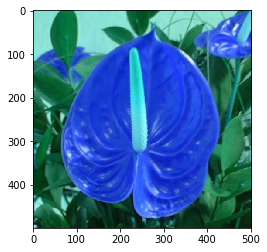

In [ ]:
# read example image
img = cv2.imread('./jpg/'+training_files[0])
 
# show image

plt.imshow(img, interpolation='nearest')
plt.show()

In [ ]:
training_files_raw = []
for image in training_files:
  training_files_raw.append(cv2.imread(img_path+image))

In [ ]:
test_files_raw = []
for image in test_files:
  test_files_raw.append(cv2.imread(img_path+image))

In [ ]:
IMG_SIZE = 224

def filter_and_center_crop(img, IMG_SIZE = 224):
  x_skip = img.shape[0]//IMG_SIZE
  y_skip = img.shape[1]//IMG_SIZE

  img = img[::x_skip,::y_skip]
  left_1,left_2 = [(img.shape[0]-IMG_SIZE)//2,(img.shape[1]-IMG_SIZE)//2]
  img = img[left_1:IMG_SIZE+left_1,left_2:IMG_SIZE+left_2]
  return img

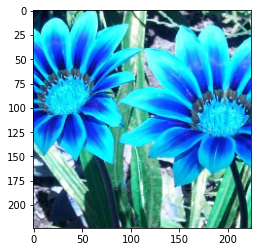

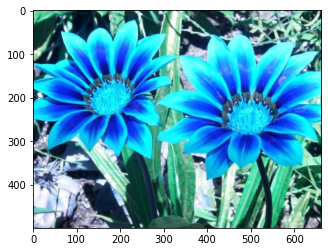

In [ ]:
# some examples

iii=1245
plt.imshow(filter_and_center_crop(training_files_raw[iii]))
plt.show()
plt.imshow((training_files_raw[iii]))
plt.show()

In [ ]:
X_train = np.array([filter_and_center_crop(f) for f in training_files_raw])
X_test = np.array([filter_and_center_crop(f) for f in test_files_raw])

y_train = training_labels
y_test = test_labels

In [ ]:
# batch generator

BATCH_SIZE = 32

def batch_gen(x, y, batch_size):
  while True:
    xbatch, ybatch = [],[]
    for i, xitem in enumerate(x):
      xbatch.append(xitem)
      ybatch.append(tf.keras.utils.to_categorical(y[i], NR_OF_Classes ))
      if i % batch_size == batch_size-1:
        yield np.array(xbatch), np.array(ybatch)
        xbatch, ybatch = [],[]

    yield np.array(xbatch), np.array(ybatch)

def rdm_batch_gen(x, y, batch_size, init_random_state=42, nr_of_classes=NR_OF_Classes):
  while True:
    x_shuffled,y_shuffled = shuffle(x,y,random_state=init_random_state)
    xbatch, ybatch = [],[]
    for i,(xitem,yitem) in enumerate(zip(x_shuffled,y_shuffled)):
      xbatch.append(xitem)
      ybatch.append(tf.keras.utils.to_categorical(yitem, nr_of_classes))
      if i % batch_size == batch_size-1:
        yield np.array(xbatch), np.array(ybatch)
        xbatch, ybatch = [],[]

    if xbatch!=[]:
      np.random.seed(init_random_state)
      addl_ind=np.random.choice(len(y), batch_size-len(xbatch))
      xbatch +=[x[i] for i in addl_ind]
      ybatch +=[tf.keras.utils.to_categorical(y[i], nr_of_classes) for i in addl_ind]
      yield np.array(xbatch), np.array(ybatch)
    init_random_state+=1
      

(32, 224, 224, 3) (32, 102)


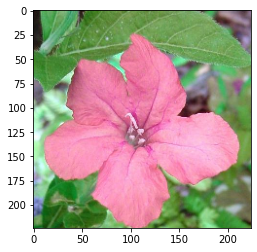

In [ ]:
# test generator
for _ in rdm_batch_gen(X_train, y_train, BATCH_SIZE):
    print(_[0].shape, _[1].shape)
    plt.imshow(_[0][0])
    break

# Retrain last 50 layers of ResNet (93.8% test accuracy in 8 epochs)

We do not use any of the techniques (discriminative learning rates and/or progressive resizing)

In [ ]:
def ResNet_mod(use_imagenet=True):
    model = tf.keras.applications.ResNet50V2(
    include_top = False,
    weights = 'imagenet' if use_imagenet else None,
    #input_tensor = None,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)#,
    #pooling = None,
    #classes = NR_OF_Classes,
    #classifier_activation = "softmax",
    )
      
    # add global pooling
    new_output = tf.keras.layers.GlobalAveragePooling2D()(model.output)
    # add new dense layer for our labels
    new_output = tf.keras.layers.Dense(NR_OF_Classes, activation='softmax')(new_output)
    model = tf.keras.Model(model.inputs, new_output)
    return model

In [ ]:
model = ResNet_mod()

#model.summary()

94668760/94668760 [==============================] - 4s 0us/step


In [ ]:
print(len(model.layers))

192


In [ ]:
# set all layers trainable by default
for layer in model.layers:
    layer.trainable = True
    #if isinstance(layer, keras.layers.BatchNormalization):
        # aggressive exponential smoothing of batch norm
        # parameters to faster adjust to our new dataset
        #layer.momentum = 0.9
    
# fix deep layers (fine-tuning only last 50)
for layer in model.layers[:-50]:
    # fix all but batch norm layers, because we neeed to update moving averages for a new dataset!
    if not isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

In [ ]:
# compile new model
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adamax(),
    metrics = ['accuracy']  # report accuracy during training
)

In [ ]:
# we will save model checkpoints to continue training in case of kernel death
model_filepath = "flowers.{epoch:02d}.hdf5"
last_finished_epoch = None

In [ ]:
# fine tune for 2 epochs (full passes through all training data)
# we make 8 epochs, where epoch is 1/8 of our training data to see progress more often
model.fit(
    rdm_batch_gen(X_train, y_train, BATCH_SIZE,\
                                    init_random_state=42,\
                                    nr_of_classes=NR_OF_Classes),
    validation_data = rdm_batch_gen(X_test, y_test,\
                                    BATCH_SIZE,\
                                    init_random_state=42,\
                                    nr_of_classes=NR_OF_Classes), 
    steps_per_epoch = len(X_train) // BATCH_SIZE // 8,
    epochs = 16,
    validation_steps = len(X_test) // BATCH_SIZE // 4,
    callbacks = [tfa.callbacks.TQDMProgressBar(),\
                 tf.keras.callbacks.ModelCheckpoint(model_filepath,\
                                                    monitor='val_accuracy',\
                                                    verbose=1,\
                                                    save_best_only=True,\
                                                    mode='max')],
    verbose=0,
    initial_epoch=last_finished_epoch or 0
)

Training:   0%|           0/16 ETA: ?s,  ?epochs/s

Epoch 1/16


0/25           ETA: ?s - 


Epoch 1: val_accuracy improved from -inf to 0.13281, saving model to flowers.01.hdf5
Epoch 2/16


0/25           ETA: ?s - 


Epoch 2: val_accuracy improved from 0.13281 to 0.32812, saving model to flowers.02.hdf5
Epoch 3/16


0/25           ETA: ?s - 


Epoch 3: val_accuracy improved from 0.32812 to 0.55990, saving model to flowers.03.hdf5
Epoch 4/16


0/25           ETA: ?s - 


Epoch 4: val_accuracy improved from 0.55990 to 0.73438, saving model to flowers.04.hdf5
Epoch 5/16


0/25           ETA: ?s - 


Epoch 5: val_accuracy improved from 0.73438 to 0.82031, saving model to flowers.05.hdf5
Epoch 6/16


0/25           ETA: ?s - 


Epoch 6: val_accuracy improved from 0.82031 to 0.82292, saving model to flowers.06.hdf5
Epoch 7/16


0/25           ETA: ?s - 


Epoch 7: val_accuracy improved from 0.82292 to 0.88542, saving model to flowers.07.hdf5
Epoch 8/16


0/25           ETA: ?s - 


Epoch 8: val_accuracy improved from 0.88542 to 0.91146, saving model to flowers.08.hdf5
Epoch 9/16


0/25           ETA: ?s - 


Epoch 9: val_accuracy improved from 0.91146 to 0.92188, saving model to flowers.09.hdf5
Epoch 10/16


0/25           ETA: ?s - 


Epoch 10: val_accuracy improved from 0.92188 to 0.94792, saving model to flowers.10.hdf5
Epoch 11/16


0/25           ETA: ?s - 


Epoch 11: val_accuracy did not improve from 0.94792
Epoch 12/16


0/25           ETA: ?s - 


Epoch 12: val_accuracy did not improve from 0.94792
Epoch 13/16


0/25           ETA: ?s - 


Epoch 13: val_accuracy improved from 0.94792 to 0.95312, saving model to flowers.13.hdf5
Epoch 14/16


0/25           ETA: ?s - 


Epoch 14: val_accuracy did not improve from 0.95312
Epoch 15/16


0/25           ETA: ?s - 


Epoch 15: val_accuracy did not improve from 0.95312
Epoch 16/16


0/25           ETA: ?s - 


Epoch 16: val_accuracy did not improve from 0.95312


In [ ]:
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Train Accuracy: {:2.3}'.format(np.sum(train_pred.argmax(axis=1)==y_train)/y_train.shape[0]))
print('Test Accuracy: {:2.3}'.format(np.sum(test_pred.argmax(axis=1)==y_test)/y_test.shape[0]))

205/205 [==============================] - 17s 84ms/step
Train Accuracy: 0.998
Test Accuracy: 0.938


# Discriminative learning rates for last 50 layers (92.7% test accuracy after 16 epochs) 

In [ ]:
model_dl = ResNet_mod()

# set all layers trainable by default
for layer in model_dl.layers:
    layer.trainable = True
    #if isinstance(layer, keras.layers.BatchNormalization):
        # we do aggressive exponential smoothing of batch norm
        # parameters to faster adjust to our new dataset
        #layer.momentum = 0.9
    
# fix deep layers (fine-tuning only last 50)
for layer in model_dl.layers[:-50]:
    # fix all but batch norm layers, because we neeed to update moving averages for a new dataset!
    if not isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

In [ ]:
lrs = [(2e-3*(.9**x)) for x in range(50)]

optimizers = [tf.keras.optimizers.Adamax(learning_rate = lr) for lr in lrs]
    
#specifying the optimizers and layers in which it will operate
optimizers_and_layers = [(optim, model_dl.layers[-i-1]) for i, optim in enumerate(optimizers)]

# Using Multi Optimizer from Tensorflow Addons
opt = tfa.optimizers.MultiOptimizer(optimizers_and_layers)

In [ ]:
# compile new model
model_dl.compile(
    loss = 'categorical_crossentropy',
    optimizer = opt,
    metrics = ['accuracy']  # report accuracy during training
)

In [ ]:
# we will save model checkpoints to continue training in case of kernel death
model_dl_filepath = "flowers_dl.{epoch:02d}.hdf5"
last_finished_epoch = None

In [ ]:
# fine tune for 2 epochs (full passes through all training data)
# we make 8 epochs, where epoch is 1/8 of our training data to see progress more often
model_dl.fit(
    rdm_batch_gen(X_train, y_train, BATCH_SIZE,\
                                    init_random_state=42,\
                                    nr_of_classes=NR_OF_Classes),
    validation_data = rdm_batch_gen(X_test, y_test,\
                                    BATCH_SIZE,\
                                    init_random_state=42,\
                                    nr_of_classes=NR_OF_Classes),
    steps_per_epoch = len(X_train) // BATCH_SIZE // 8,
    epochs = 16, 
    validation_steps = len(X_test) // BATCH_SIZE // 4,
    callbacks = [tfa.callbacks.TQDMProgressBar(),\
                 tf.keras.callbacks.ModelCheckpoint(model_dl_filepath,\
                                                    monitor='val_accuracy',\
                                                    verbose=1,\
                                                    save_best_only=True,\
                                                    mode='max')],
    verbose=0,
    initial_epoch=last_finished_epoch or 0
)

Training:   0%|           0/16 ETA: ?s,  ?epochs/s

Epoch 1/16


0/25           ETA: ?s - 


Epoch 1: val_accuracy improved from -inf to 0.84115, saving model to flowers_dl.01.hdf5
Epoch 2/16


0/25           ETA: ?s - 


Epoch 2: val_accuracy improved from 0.84115 to 0.89844, saving model to flowers_dl.02.hdf5
Epoch 3/16


0/25           ETA: ?s - 


Epoch 3: val_accuracy did not improve from 0.89844
Epoch 4/16


0/25           ETA: ?s - 


Epoch 4: val_accuracy did not improve from 0.89844
Epoch 5/16


0/25           ETA: ?s - 


Epoch 5: val_accuracy improved from 0.89844 to 0.90625, saving model to flowers_dl.05.hdf5
Epoch 6/16


0/25           ETA: ?s - 


Epoch 6: val_accuracy did not improve from 0.90625
Epoch 7/16


0/25           ETA: ?s - 


Epoch 7: val_accuracy improved from 0.90625 to 0.90885, saving model to flowers_dl.07.hdf5
Epoch 8/16


0/25           ETA: ?s - 


Epoch 8: val_accuracy did not improve from 0.90885
Epoch 9/16


0/25           ETA: ?s - 


Epoch 9: val_accuracy did not improve from 0.90885
Epoch 10/16


0/25           ETA: ?s - 


Epoch 10: val_accuracy improved from 0.90885 to 0.93490, saving model to flowers_dl.10.hdf5
Epoch 11/16


0/25           ETA: ?s - 


Epoch 11: val_accuracy did not improve from 0.93490
Epoch 12/16


0/25           ETA: ?s - 


Epoch 12: val_accuracy did not improve from 0.93490
Epoch 13/16


0/25           ETA: ?s - 


Epoch 13: val_accuracy did not improve from 0.93490
Epoch 14/16


0/25           ETA: ?s - 


Epoch 14: val_accuracy did not improve from 0.93490
Epoch 15/16


0/25           ETA: ?s - 


Epoch 15: val_accuracy improved from 0.93490 to 0.93750, saving model to flowers_dl.15.hdf5
Epoch 16/16


0/25           ETA: ?s - 


Epoch 16: val_accuracy did not improve from 0.93750


In [ ]:
test_pred_dl = model_dl.predict(X_test)
train_pred_dl = model_dl.predict(X_train)

print('Train Accuracy: {:2.3}'.format(np.sum(train_pred_dl.argmax(axis=1)==y_train)/y_train.shape[0]))
print('Test Accuracy: {:2.3}'.format(np.sum(test_pred_dl.argmax(axis=1)==y_test)/y_test.shape[0]))

205/205 [==============================] - 17s 82ms/step
Train Accuracy: 1.0
Test Accuracy: 0.927


# Progressive resizing (95.1% test accuracy)

## 56x56 (60.2% test accuracy after 16 epochs):

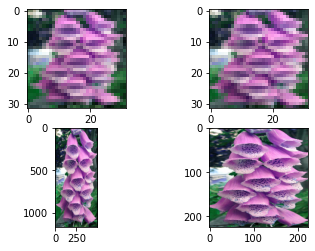

In [ ]:
# better way of resizing

import PIL
from PIL import Image

f, axarr = plt.subplots(2,2)

iii = 1819

im = Image.fromarray(training_files_raw[iii])
size = tuple([32,32])
new_image = np.array(im.resize(size, PIL.Image.BICUBIC))
new_image_from_Xt = np.array(Image.fromarray(X_train[iii]).resize(size, PIL.Image.BICUBIC))

axarr[0,0].imshow((new_image))
axarr[0,1].imshow((new_image_from_Xt))
axarr[1,0].imshow((training_files_raw[iii]))
axarr[1,1].imshow((X_train[iii]))
plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

img_size = 56

size = tuple([img_size,img_size])

X_train56 = np.array([np.array(Image.fromarray(x).resize(size, PIL.Image.BICUBIC)) for x in X_train])
X_test56 = np.array([np.array(Image.fromarray(x).resize(size, PIL.Image.BICUBIC)) for x in X_test])

prior = tf.keras.applications.ResNet50V2(
  include_top = False,
  weights = 'imagenet',
  #input_tensor = None,
  input_shape=(img_size, img_size, 3)
  )

model_pr = Sequential()
model_pr.add(prior)
model_pr.add(tf.keras.layers.GlobalAveragePooling2D())
model_pr.add(tf.keras.layers.Dense(NR_OF_Classes, activation='softmax'))


for resnet_layer in model_pr.layers[0].layers:
  resnet_layer.trainable = True
  if isinstance(resnet_layer, keras.layers.BatchNormalization):
    layer.momentum = 0.9
#model_pr.layers[0].trainable = False
    
# fix deep layers (fine-tuning only last 50)
for resnet_layer in model_pr.layers[0].layers[:-48]:
  if not isinstance(resnet_layer, keras.layers.BatchNormalization):
    resnet_layer.trainable = False

# compile the model

model_pr.compile(
    optimizer=tf.keras.optimizers.Adamax(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_pr.save('./model_56.h5')

In [ ]:
model_pr.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 102)               208998    
                                                                 
Total params: 23,773,798
Trainable params: 16,319,974
Non-trainable params: 7,453,824
_________________________________________________________________


In [ ]:
# we will save model checkpoints to continue training in case of kernel death
model_pr_filepath = "flowers_pr_56.{epoch:02d}.hdf5"
last_finished_epoch = None

In [ ]:
model_pr.fit(
    rdm_batch_gen(X_train56, y_train,BATCH_SIZE,\
                                    init_random_state=42,\
                                    nr_of_classes=NR_OF_Classes), 
    validation_data = rdm_batch_gen(X_test56, y_test,\
                                    BATCH_SIZE,\
                                    init_random_state=42,\
                                    nr_of_classes=NR_OF_Classes), 
    steps_per_epoch = len(X_train) // BATCH_SIZE // 8,
    epochs = 2 * 8,
    validation_steps = len(X_test) // BATCH_SIZE // 4,
    callbacks = [tfa.callbacks.TQDMProgressBar(),\
                 tf.keras.callbacks.ModelCheckpoint(model_pr_filepath,\
                                                    monitor='val_accuracy',\
                                                    verbose=1,\
                                                    save_best_only=True,\
                                                    mode='max')],
    verbose=0,
    initial_epoch=last_finished_epoch or 0
)

Training:   0%|           0/16 ETA: ?s,  ?epochs/s

Epoch 1/16


0/25           ETA: ?s - 


Epoch 1: val_accuracy improved from -inf to 0.04167, saving model to flowers_pr_56.01.hdf5
Epoch 2/16


0/25           ETA: ?s - 


Epoch 2: val_accuracy improved from 0.04167 to 0.06510, saving model to flowers_pr_56.02.hdf5
Epoch 3/16


0/25           ETA: ?s - 


Epoch 3: val_accuracy improved from 0.06510 to 0.16146, saving model to flowers_pr_56.03.hdf5
Epoch 4/16


0/25           ETA: ?s - 


Epoch 4: val_accuracy improved from 0.16146 to 0.20833, saving model to flowers_pr_56.04.hdf5
Epoch 5/16


0/25           ETA: ?s - 


Epoch 5: val_accuracy improved from 0.20833 to 0.27865, saving model to flowers_pr_56.05.hdf5
Epoch 6/16


0/25           ETA: ?s - 


Epoch 6: val_accuracy improved from 0.27865 to 0.35417, saving model to flowers_pr_56.06.hdf5
Epoch 7/16


0/25           ETA: ?s - 


Epoch 7: val_accuracy improved from 0.35417 to 0.48177, saving model to flowers_pr_56.07.hdf5
Epoch 8/16


0/25           ETA: ?s - 


Epoch 8: val_accuracy did not improve from 0.48177
Epoch 9/16


0/25           ETA: ?s - 


Epoch 9: val_accuracy improved from 0.48177 to 0.50000, saving model to flowers_pr_56.09.hdf5
Epoch 10/16


0/25           ETA: ?s - 


Epoch 10: val_accuracy improved from 0.50000 to 0.55469, saving model to flowers_pr_56.10.hdf5
Epoch 11/16


0/25           ETA: ?s - 


Epoch 11: val_accuracy did not improve from 0.55469
Epoch 12/16


0/25           ETA: ?s - 


Epoch 12: val_accuracy did not improve from 0.55469
Epoch 13/16


0/25           ETA: ?s - 


Epoch 13: val_accuracy improved from 0.55469 to 0.61198, saving model to flowers_pr_56.13.hdf5
Epoch 14/16


0/25           ETA: ?s - 


Epoch 14: val_accuracy did not improve from 0.61198
Epoch 15/16


0/25           ETA: ?s - 


Epoch 15: val_accuracy did not improve from 0.61198
Epoch 16/16


0/25           ETA: ?s - 


Epoch 16: val_accuracy did not improve from 0.61198


In [ ]:
test_pred_pr = model_pr.predict(X_test56)
train_pred_pr = model_pr.predict(X_train56)

print('Train Accuracy: {:2.3}'.format(np.sum(train_pred_pr.argmax(axis=1)==y_train)/y_train.shape[0]))
print('Test Accuracy: {:2.3}'.format(np.sum(test_pred_pr.argmax(axis=1)==y_test)/y_test.shape[0]))

205/205 [==============================] - 3s 15ms/step
Train Accuracy: 0.92
Test Accuracy: 0.602


In [ ]:
model_pr.save('./model_56.h5')

## 112x112 (84.2% test accuracy after 16 epochs):

In [ ]:
from keras.models import load_model

In [ ]:
prior = load_model('model_56.h5')

In [ ]:
img_size = 112

size = tuple([img_size,img_size])

X_train112 = np.array([np.array(Image.fromarray(x).resize(size, PIL.Image.BICUBIC)) for x in X_train])
X_test112 = np.array([np.array(Image.fromarray(x).resize(size, PIL.Image.BICUBIC)) for x in X_test])

prior_112 = tf.keras.applications.ResNet50V2(
  include_top = False,
  weights = 'imagenet',
  #input_tensor = None,
  input_shape=(img_size, img_size, 3)
  )

model_pr_112 = Sequential()
model_pr_112.add(prior_112)
model_pr_112.add(tf.keras.layers.GlobalAveragePooling2D())
model_pr_112.add(tf.keras.layers.Dense(NR_OF_Classes, activation='softmax'))


for resnet_layer in model_pr_112.layers[0].layers:
  resnet_layer.trainable = True
  if isinstance(resnet_layer, keras.layers.BatchNormalization):
    layer.momentum = 0.9
#model_pr.layers[0].trainable = False
    
# fix deep layers (fine-tuning only last 50)
for resnet_layer in model_pr_112.layers[0].layers[:-48]:
  if not isinstance(resnet_layer, keras.layers.BatchNormalization):
    resnet_layer.trainable = False

# compile the model

model_pr_112.compile(
    optimizer=tf.keras.optimizers.Adamax(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_pr_112.save('./model_112.h5')

In [ ]:
model_pr_112.load_weights('./model_56.h5')

In [ ]:
model_pr_112.fit(
    rdm_batch_gen(X_train112, y_train,BATCH_SIZE,\
                                    init_random_state=42,\
                                    nr_of_classes=NR_OF_Classes), 
    validation_data = rdm_batch_gen(X_test112, y_test,\
                                    BATCH_SIZE,\
                                    init_random_state=42,\
                                    nr_of_classes=NR_OF_Classes), 
    steps_per_epoch = len(X_train) // BATCH_SIZE // 8,
    epochs = 2 * 8,
    validation_steps = len(X_test) // BATCH_SIZE // 4,
    callbacks = [tfa.callbacks.TQDMProgressBar(),\
                 tf.keras.callbacks.ModelCheckpoint(model_pr_filepath,\
                                                    monitor='val_accuracy',\
                                                    verbose=1,\
                                                    save_best_only=True,\
                                                    mode='max')],
    verbose=0,
    initial_epoch=last_finished_epoch or 0
)

Training:   0%|           0/16 ETA: ?s,  ?epochs/s

Epoch 1/16


0/25           ETA: ?s - 


Epoch 1: val_accuracy improved from -inf to 0.37240, saving model to flowers_pr_56.01.hdf5
Epoch 2/16


0/25           ETA: ?s - 


Epoch 2: val_accuracy improved from 0.37240 to 0.50781, saving model to flowers_pr_56.02.hdf5
Epoch 3/16


0/25           ETA: ?s - 


Epoch 3: val_accuracy improved from 0.50781 to 0.68750, saving model to flowers_pr_56.03.hdf5
Epoch 4/16


0/25           ETA: ?s - 


Epoch 4: val_accuracy improved from 0.68750 to 0.69010, saving model to flowers_pr_56.04.hdf5
Epoch 5/16


0/25           ETA: ?s - 


Epoch 5: val_accuracy improved from 0.69010 to 0.74479, saving model to flowers_pr_56.05.hdf5
Epoch 6/16


0/25           ETA: ?s - 


Epoch 6: val_accuracy improved from 0.74479 to 0.75521, saving model to flowers_pr_56.06.hdf5
Epoch 7/16


0/25           ETA: ?s - 


Epoch 7: val_accuracy improved from 0.75521 to 0.80208, saving model to flowers_pr_56.07.hdf5
Epoch 8/16


0/25           ETA: ?s - 


Epoch 8: val_accuracy did not improve from 0.80208
Epoch 9/16


0/25           ETA: ?s - 


Epoch 9: val_accuracy improved from 0.80208 to 0.80990, saving model to flowers_pr_56.09.hdf5
Epoch 10/16


0/25           ETA: ?s - 


Epoch 10: val_accuracy improved from 0.80990 to 0.86719, saving model to flowers_pr_56.10.hdf5
Epoch 11/16


0/25           ETA: ?s - 


Epoch 11: val_accuracy did not improve from 0.86719
Epoch 12/16


0/25           ETA: ?s - 


Epoch 12: val_accuracy did not improve from 0.86719
Epoch 13/16


0/25           ETA: ?s - 


Epoch 13: val_accuracy did not improve from 0.86719
Epoch 14/16


0/25           ETA: ?s - 


Epoch 14: val_accuracy did not improve from 0.86719
Epoch 15/16


0/25           ETA: ?s - 


Epoch 15: val_accuracy did not improve from 0.86719
Epoch 16/16


0/25           ETA: ?s - 


Epoch 16: val_accuracy did not improve from 0.86719


In [ ]:
test_pred_pr_112 = model_pr_112.predict(X_test112)
train_pred_pr_112 = model_pr_112.predict(X_train112)

print('Train Accuracy: {:2.3}'.format(np.sum(train_pred_pr_112.argmax(axis=1)==y_train)/y_train.shape[0]))
print('Test Accuracy: {:2.3}'.format(np.sum(test_pred_pr_112.argmax(axis=1)==y_test)/y_test.shape[0]))

205/205 [==============================] - 6s 30ms/step
Train Accuracy: 0.997
Test Accuracy: 0.842


In [ ]:
model_pr_112.save('./model_112.h5')

## 224x224 (95.1% test accuracy after 16 epochs):

In [ ]:
img_size = 224

size = tuple([img_size,img_size])

X_train224 = np.array([np.array(Image.fromarray(x).resize(size, PIL.Image.BICUBIC)) for x in X_train])
X_test224 = np.array([np.array(Image.fromarray(x).resize(size, PIL.Image.BICUBIC)) for x in X_test])

prior_224 = tf.keras.applications.ResNet50V2(
  include_top = False,
  weights = 'imagenet',
  #input_tensor = None,
  input_shape=(img_size, img_size, 3)
  )

model_pr_224 = Sequential()
model_pr_224.add(prior_224)
model_pr_224.add(tf.keras.layers.GlobalAveragePooling2D())
model_pr_224.add(tf.keras.layers.Dense(NR_OF_Classes, activation='softmax'))


for resnet_layer in model_pr_224.layers[0].layers:
  resnet_layer.trainable = True
  if isinstance(resnet_layer, keras.layers.BatchNormalization):
    layer.momentum = 0.9
#model_pr.layers[0].trainable = False
    
# fix deep layers (fine-tuning only last 50)
for resnet_layer in model_pr_224.layers[0].layers[:-48]:
  if not isinstance(resnet_layer, keras.layers.BatchNormalization):
    resnet_layer.trainable = False

# compile the model

model_pr_224.compile(
    optimizer=tf.keras.optimizers.Adamax(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_pr_224.save('./model_224.h5')

In [ ]:
model_pr_224.load_weights('./model_112.h5')

In [ ]:
model_pr_224.fit(
    rdm_batch_gen(X_train224, y_train,BATCH_SIZE,\
                                    init_random_state=42,\
                                    nr_of_classes=NR_OF_Classes), 
    validation_data = rdm_batch_gen(X_test224, y_test,\
                                    BATCH_SIZE,\
                                    init_random_state=42,\
                                    nr_of_classes=NR_OF_Classes), 
    steps_per_epoch = len(X_train) // BATCH_SIZE // 8,
    epochs = 2 * 8,
    validation_steps = len(X_test) // BATCH_SIZE // 4,
    callbacks = [tfa.callbacks.TQDMProgressBar(),\
                 tf.keras.callbacks.ModelCheckpoint(model_pr_filepath,\
                                                    monitor='val_accuracy',\
                                                    verbose=1,\
                                                    save_best_only=True,\
                                                    mode='max')],
    verbose=0,
    initial_epoch=last_finished_epoch or 0
)

Training:   0%|           0/16 ETA: ?s,  ?epochs/s

Epoch 1/16


0/25           ETA: ?s - 


Epoch 1: val_accuracy improved from -inf to 0.61719, saving model to flowers_pr_56.01.hdf5
Epoch 2/16


0/25           ETA: ?s - 


Epoch 2: val_accuracy improved from 0.61719 to 0.66406, saving model to flowers_pr_56.02.hdf5
Epoch 3/16


0/25           ETA: ?s - 


Epoch 3: val_accuracy improved from 0.66406 to 0.79948, saving model to flowers_pr_56.03.hdf5
Epoch 4/16


0/25           ETA: ?s - 


Epoch 4: val_accuracy improved from 0.79948 to 0.82812, saving model to flowers_pr_56.04.hdf5
Epoch 5/16


0/25           ETA: ?s - 


Epoch 5: val_accuracy improved from 0.82812 to 0.88542, saving model to flowers_pr_56.05.hdf5
Epoch 6/16


0/25           ETA: ?s - 


Epoch 6: val_accuracy did not improve from 0.88542
Epoch 7/16


0/25           ETA: ?s - 


Epoch 7: val_accuracy improved from 0.88542 to 0.91146, saving model to flowers_pr_56.07.hdf5
Epoch 8/16


0/25           ETA: ?s - 


Epoch 8: val_accuracy did not improve from 0.91146
Epoch 9/16


0/25           ETA: ?s - 


Epoch 9: val_accuracy improved from 0.91146 to 0.93490, saving model to flowers_pr_56.09.hdf5
Epoch 10/16


0/25           ETA: ?s - 


Epoch 10: val_accuracy improved from 0.93490 to 0.95312, saving model to flowers_pr_56.10.hdf5
Epoch 11/16


0/25           ETA: ?s - 


Epoch 11: val_accuracy did not improve from 0.95312
Epoch 12/16


0/25           ETA: ?s - 


Epoch 12: val_accuracy did not improve from 0.95312
Epoch 13/16


0/25           ETA: ?s - 


Epoch 13: val_accuracy did not improve from 0.95312
Epoch 14/16


0/25           ETA: ?s - 


Epoch 14: val_accuracy did not improve from 0.95312
Epoch 15/16


0/25           ETA: ?s - 


Epoch 15: val_accuracy did not improve from 0.95312
Epoch 16/16


0/25           ETA: ?s - 


Epoch 16: val_accuracy did not improve from 0.95312


In [ ]:
test_pred_pr_224 = model_pr_224.predict(X_test224)
train_pred_pr_224 = model_pr_224.predict(X_train224)

print('Train Accuracy: {:2.3}'.format(np.sum(train_pred_pr_224.argmax(axis=1)==y_train)/y_train.shape[0]))
print('Test Accuracy: {:2.3}'.format(np.sum(test_pred_pr_224.argmax(axis=1)==y_test)/y_test.shape[0]))

205/205 [==============================] - 16s 78ms/step
Train Accuracy: 0.999
Test Accuracy: 0.951


# Combine progressive resizing and discriminative learning rates